In [12]:
import tweepy
import time
import pandas as pd
from textblob import TextBlob
#French adaptor
import re
import numpy as np
import operator
import matplotlib.pyplot as plt
import IPython.display as display
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
%matplotlib inline

In [ ]:
auth = tweepy.auth.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

if(api.verify_credentials):
    print('We sucessfully logged in')

In [4]:
def paginate(iterable, page_size):
    while True:
        i1, i2 = itertools.tee(iterable)
        iterable, page = (itertools.islice(i1, page_size, None),
                list(itertools.islice(i2, page_size)))
        if len(page) == 0:
            break
        yield page

In [17]:
followers = api.followers_ids(screen_name='SudipDutta')

In [19]:
list_of_users=[]
for page in paginate(followers, 100):
    results = api.lookup_users(user_ids=page)
    for result in results:
        list_of_users.append(result.screen_name)

In [22]:
len(list_of_users)

331

In [23]:
list_of_followers=pd.DataFrame()
list_of_followers['followers']=''
list_of_followers['followers']=list_of_users
list_of_followers.to_csv('/home/ashwin/Downloads/list_of_followers.csv',index=False)

In [24]:
sentiment_of_tweets=[]
users_list=[]
tweet_list=[]
count=0
for user in list_of_users:
    this_candidate_tweets = tweepy.Cursor(api.user_timeline, screen_name=user,count=200).items()
    try:
        for tweet in this_candidate_tweets:
            tweet=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.text).split())
            analysis = TextBlob(tweet)
            users_list.append(user)
            tweet_list.append(tweet)
            if analysis.sentiment.polarity > 0:
                    sentiment_of_tweets.append('positive')
            elif analysis.sentiment.polarity == 0:
                    sentiment_of_tweets.append('neutral')
            else:
                    sentiment_of_tweets.append('negative')
    except tweepy.TweepError as e:
            count=count+1
            continue

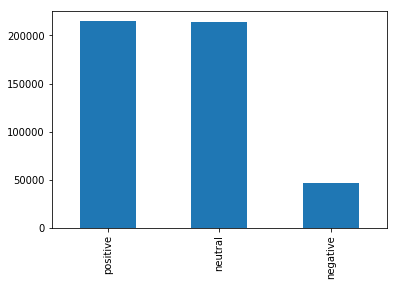

In [18]:
senti=pd.read_csv('/home/ashwin/Downloads/twitter_sentiment_analysis/sentiment_analysis_of_the_followers.csv')
#senti=pd.DataFrame()
#senti['users']=users_list
#senti['tweets']=tweet_list
#senti['sentiment']=sentiment_of_tweets
senti['sentiment'].value_counts().plot(kind='bar')

In [19]:
senti['sentiment'].value_counts()

positive    215019
neutral     214173
negative     46314
Name: sentiment, dtype: int64

In [20]:
classify_followers=senti[((senti['sentiment']=='positive') |
                          (senti['sentiment']=='negative'))]

In [21]:
print(classify_followers.shape)
print(classify_followers['sentiment'].value_counts())
a=classify_followers['sentiment'].value_counts()

(261333, 4)
positive    215019
negative     46314
Name: sentiment, dtype: int64


In [22]:
set(classify_followers['sentiment'])

{'negative', 'positive'}

In [23]:
users=set(classify_followers['users'])

In [24]:
classify_followers[(classify_followers['sentiment']=='negative')]['sentiment']\
    .count()

46314

In [29]:
user_to_classify=[]
classify=[]
for user in users:
    user_to_classify.append(user)
    temp=classify_followers[(classify_followers['users']==user)]
    if(temp.shape[0]>1):
        if(('positive' in set(temp['sentiment'])) 
           and ('negative' in set(temp['sentiment'])) ):
            positive_count=temp[(temp['sentiment']=='positive')]['sentiment'].count()
            negetive_count=temp[(temp['sentiment']=='negative')]['sentiment'].count()
            positive_percent=(positive_count/temp.shape[0])*100
            negetive_percent=(negetive_count/temp.shape[0])*100
            if(negetive_percent>=34):
                classify.append('negative')
            else:
                classify.append('positive')
        else:
            if('positive' in set(temp['sentiment'])):
                classify.append('positive')
            else:
                classify.append('negative')
    else:
        if('positive' in set(temp['sentiment'])):
            classify.append('positive')
        else:
            classify.append('negative')

In [28]:
#senti=pd.read_csv('/home/ashwin/Downloads/followers_classification.csv')
followers_classification=pd.DataFrame()
followers_classification['users']=user_to_classify
followers_classification['sentiment']=classify
followers_classification['sentiment'].value_counts().plot(kind='bar')

positive    279
negative     19
Name: sentiment, dtype: int64

In [ ]:
print(count)

In [74]:
followers_classification\
    .to_csv('/home/ashwin/Downloads/followers_classification.csv',index=False)

In [1]:
user_requested=input('enter the user for the tweet analysis')

In [ ]:
if(user_requested in list_of_users):
    temp=senti[(senti.users==user_requested)]
    temp['sentiment'].value_counts().plot(kind='bar')
else:
    print('no user is found')

In [69]:
data=pd.read_csv('/home/ashwin/Downloads/twitter_sentiment_analysis/'
                 'sentiment_analysis_of_the_followers.csv',na_filter=False)

In [70]:
data.shape

(475506, 4)

In [97]:
df=data[((data['sentiment']=='negative') | (data['sentiment']=='positive'))]
#print(data.isnull().sum())
#data['tweets'].fillna("unkonwn value")
#print(data.isnull().sum())
df.shape

(261333, 4)

In [87]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['tweets'])
 
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++'
               , max_iter=10000, n_init=1)
model.fit(X)
 
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
    print
    
labels=model.labels_
print( np.bincount(labels))

Top terms per cluster:
Cluster 0:
 thanks
 follow
 sharing
 connect
 great
 week
 community
 following
 recent
 connecting
 indiegogo
 gt
 coding
 nation
 happy
 campaign
 check
 followers
 hey
 linkedin
Cluster 1:
 rt
 sales
 new
 great
 amp
 marketing
 social
 best
 good
 business
 free
 love
 success
 time
 people
 startup
 media
 make
 just
 like
[ 11496 249837]


In [88]:
print(set(labels))
#classify=[x for i in labels if(i==)]
d=pd.DataFrame()
d['labels']=labels
d['senti']=df['sentiment']
d['labels'].value_counts()

{0, 1}


1    249837
0     11496
Name: labels, dtype: int64

In [95]:
a=[i for i in range(0,len(labels)) if((d['senti'][i]=='positive') 
                                      and d['labels'][i]==1)]
b=[i for i in range(0,len(labels)) if((d['senti'][i]=='positive') 
                                      and d['labels'][i]==0)]
c=[i for i in range(0,len(labels)) if((d['senti'][i]=='negative') 
                                      and d['labels'][i]==1)]
d=[i for i in range(0,len(labels)) if((d['senti'][i]=='negative') 
                                      and d['labels'][i]==0)]

In [96]:
print(len(a),len(b),len(c),len(d))

109735 5053 24006 1210


In [112]:
users=set(df['users'])
prediction=[]
for user in users:
    temp=df[(df['users']==user)]
    temp=temp['tweets']
    Y = vectorizer.transform(temp)
    tweet_predictions=model.predict(Y)
    no_one=np.count_nonzero(tweet_predictions==1)
    no_zero=np.count_nonzero(tweet_predictions==0)
    if(no_one>no_zero):
        prediction.append('positive')
    else:
        prediction.append('negative')

In [113]:
print(prediction.count('positive'))
print(prediction.count('negative'))

294
4
